In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [3]:
# data from earlier
with open('models/2019-05-19T001217-UTC-outdata.pkl', 'rb') as fd: outdata = pickle.load(fd)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,  dropout=0.2, recurrent_dropout=0.2,
                input_shape=(None, 1)
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
%time training_indices = \
        mu.choose_training_indices(outdata, [10000, 7689, 10000, 20000])

training_groups = training_indices
training_indices = training_groups[0] + training_groups[1]\
                    + training_groups[2] + training_groups[3]


CPU times: user 4.44 s, sys: 32.9 ms, total: 4.47 s
Wall time: 4.53 s


In [8]:
#Hand-tuned ... 
class_weights = {0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}

%time dataset_batches = mu.build_dataset_weighty(  \
    outdata, training_indices, class_weights, \
        batch_size=1000)

Counter({3: 20000, 0: 10000, 2: 10000, 1: 7689})
weights_per_class,  tf.Tensor([9.99999975e-06 6.50279617e-05 9.99999975e-06 1.50000005e-05], shape=(4,), dtype=float32)
tf.Tensor(1.0005401, shape=(), dtype=float32)
CPU times: user 8.02 s, sys: 858 ms, total: 8.88 s
Wall time: 10.4 s


In [9]:
loss_history = ipdb.runcall(mu.do_train, model, dataset_batches)

> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(125)do_train()
    124 def do_train(model, dataset_batches):
--> 125     optimizer = tf.train.AdamOptimizer()
    126 

ipdb> n
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(127)do_train()
    126 
--> 127     loss_history = []
    128 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(129)do_train()
    128 
--> 129     for (batch, (invec, labels, weights)) in enumerate(dataset_batches.take(1000)):
    130 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(131)do_train()
    130 
--> 131         with tf.GradientTape() as tape:
    132             logits = model(invec, training=True)

ipdb> n
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(132)do_train()
    131        

ipdb> pp tf.cast(np.argmax(logits[:10], axis=1), tf.float64)* tf.cast(labels[:10], tf.float64)
<tf.Tensor: id=415221, shape=(10,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>
ipdb> pp tf.count_nonzero(tf.cast(np.argmax(logits[:10], axis=1), tf.float64)* tf.cast(labels[:10], tf.float64))
<tf.Tensor: id=415240, shape=(), dtype=int64, numpy=0>
ipdb> quit


In [ ]:
# As  I'm observing the loss_history, the one thing that stands out is that they are 
# extremely small values. And I have a feeling that's because the targets are very small,
# and the predictions are very small, so the calculated cross entropy is also very small!..

# taking a detour.... to try to use an f1 as a loss instead.. 

In [33]:
# Getting a ValueError: No gradients provided for any variable: ["<tf.Variable 'lstm/kernel:0' shape=(1, 256) dtype=float32
# error and I am learning it's because loss_Value tensor, needs to be derived,
#    from the tensors used to train the model, per https://stackoverflow.com/questions/37889125/tensorflow-valueerror-no-gradients-provided-for-any-variable
# So perhaps tensor only operations allowed... 


reload(mu)
loss_history = ipdb.runcall(mu.do_train_f1_loss, model, dataset_batches)

> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(155)do_train_f1_loss()
    154 def do_train_f1_loss(model, dataset_batches):
--> 155     optimizer = tf.train.AdamOptimizer()
    156 

ipdb> n
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(157)do_train_f1_loss()
    156 
--> 157     loss_history = []
    158 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(159)do_train_f1_loss()
    158 
--> 159     for (batch, (invec, labels, weights)) in enumerate(dataset_batches.take(1000)):
    160 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(161)do_train_f1_loss()
    160 
--> 161         with tf.GradientTape() as tape:
    162             logits = model(invec, training=True)

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/

ipdb> c


ValueError: No gradients provided for any variable: ["<tf.Variable 'lstm/kernel:0' shape=(1, 256) dtype=float32, numpy=\narray([[-0.13525026,  0.03569452,  0.00168721,  0.03864059, -0.09212811,\n         0.14752029,  0.01056427,  0.08459091, -0.1419793 , -0.08902799,\n        -0.10010253, -0.11723363,  0.07171886,  0.03446068, -0.15215907,\n         0.11365075,  0.09912543, -0.11810257,  0.0839311 , -0.06348969,\n        -0.10529437, -0.14483319, -0.14117582,  0.14744128, -0.11637095,\n         0.11842023, -0.12055869,  0.01025772,  0.15068878,  0.00694183,\n         0.01208316,  0.14620371, -0.14925599, -0.05292388, -0.09878346,\n         0.06136915,  0.0526899 , -0.13075337,  0.1098517 ,  0.05186966,\n        -0.02966288,  0.09453502,  0.07107453, -0.07356895, -0.14546718,\n         0.0497784 , -0.09493862, -0.03619222,  0.06422989,  0.12252103,\n        -0.05925597,  0.00605452,  0.10291995, -0.0541471 ,  0.0863802 ,\n        -0.13485256,  0.13169457, -0.10669799, -0.05436414,  0.14366885,\n         0.11445262, -0.03981503,  0.05280954, -0.1339996 , -0.02276531,\n        -0.1294275 , -0.13519032, -0.0793873 ,  0.02407046, -0.00729017,\n        -0.06889643,  0.1232738 ,  0.01349281, -0.12581608,  0.08188131,\n         0.01008752,  0.10754178, -0.14026287,  0.12754713, -0.08317546,\n         0.04173739, -0.02891689, -0.06653841, -0.03083871, -0.05877732,\n         0.13126092, -0.00611635,  0.03198856,  0.02204311,  0.02957457,\n         0.07543962, -0.10564373, -0.01545933, -0.14525194, -0.02102993,\n         0.12433325, -0.05376718,  0.0819113 ,  0.02300808,  0.08300996,\n        -0.04364622, -0.0519866 , -0.15169361, -0.05157539,  0.13948347,\n         0.12718816, -0.03578855,  0.12604912,  0.12233789,  0.13412888,\n        -0.06603   ,  0.11305018,  0.14504795, -0.10134658,  0.08779992,\n         0.03865269,  0.00993128, -0.01318356, -0.1191643 ,  0.13138665,\n         0.05337852, -0.10573742, -0.06991572, -0.04248267,  0.01717339,\n         0.12960736,  0.13623966,  0.05752401, -0.11981566,  0.13477062,\n        -0.14838813, -0.01879832,  0.07737742, -0.05551443,  0.12058641,\n         0.02623023, -0.03598895, -0.03829193, -0.073803  ,  0.1257857 ,\n        -0.12818708, -0.11901556,  0.01193462, -0.14763209,  0.0234758 ,\n         0.04654357, -0.13190281, -0.12297352,  0.13750492,  0.0079927 ,\n         0.14215581, -0.00438359,  0.05444206, -0.06365898, -0.10446452,\n         0.11123233, -0.06069586,  0.10841759,  0.10974382,  0.071621  ,\n         0.00567231,  0.10080336,  0.1349989 , -0.06923872, -0.07330709,\n        -0.0477214 ,  0.0920971 ,  0.0394679 ,  0.1361533 ,  0.09280843,\n         0.03349559, -0.04652332, -0.04213429,  0.03907967,  0.12125032,\n         0.06319006,  0.00173162,  0.06742392,  0.07137518, -0.0964658 ,\n         0.00456691, -0.02091165, -0.1436546 , -0.14056107,  0.11122201,\n        -0.08518733, -0.02078524, -0.01680689, -0.01089101, -0.03693581,\n        -0.05911921,  0.07566081, -0.02838509,  0.0100323 ,  0.09455633,\n        -0.02120309,  0.03067653, -0.0293583 , -0.1263576 ,  0.01500838,\n        -0.12734284, -0.14272577,  0.01327986,  0.12134947,  0.08421096,\n         0.06578651,  0.09705144,  0.01763387, -0.14183132,  0.03532521,\n        -0.00700635, -0.00043274, -0.04783542, -0.00331651, -0.07144181,\n        -0.14850493,  0.09699428,  0.13723268,  0.04715113,  0.0104364 ,\n        -0.05919352, -0.13772565,  0.08420978,  0.0834274 ,  0.02012704,\n        -0.14252482, -0.0177516 , -0.09321775, -0.02328676, -0.04189011,\n         0.03356354, -0.15137202, -0.0635393 ,  0.00993027, -0.13446444,\n        -0.07634751,  0.11122067,  0.128635  ,  0.01685126, -0.00742652,\n        -0.04994296, -0.00430512, -0.10005181, -0.11812618,  0.0318317 ,\n        -0.09891723, -0.06324065,  0.04750155,  0.05866694, -0.10159922,\n         0.09549114, -0.01542228, -0.05120701, -0.03615463, -0.0889281 ,\n         0.13269512]], dtype=float32)>", "<tf.Variable 'lstm/recurrent_kernel:0' shape=(64, 256) dtype=float32, numpy=\narray([[-0.07686234,  0.07892677,  0.03551601, ...,  0.10877464,\n        -0.01912092,  0.0569455 ],\n       [ 0.03789634,  0.10475445,  0.02047272, ..., -0.03330812,\n         0.03831289,  0.07860027],\n       [-0.08368137, -0.08135088, -0.05140793, ...,  0.08196655,\n         0.00549076, -0.0752095 ],\n       ...,\n       [ 0.10606406,  0.04546431,  0.04949185, ...,  0.07832268,\n         0.05259805,  0.04636742],\n       [ 0.05318497,  0.00283271, -0.01018347, ...,  0.03728179,\n         0.00636323, -0.0254452 ],\n       [-0.03007535,  0.06833358,  0.02895932, ...,  0.12637116,\n         0.20674746, -0.09546624]], dtype=float32)>", "<tf.Variable 'lstm/bias:0' shape=(256,) dtype=float32, numpy=\narray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,\n       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,\n       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,\n       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,\n       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0.], dtype=float32)>", "<tf.Variable 'dense/kernel:0' shape=(64, 4) dtype=float32, numpy=\narray([[-0.08161356,  0.00486475,  0.28791505,  0.14552337],\n       [-0.25036222,  0.11820635,  0.03344685,  0.09134206],\n       [ 0.13866422, -0.06512029, -0.2467349 ,  0.21068376],\n       [ 0.06010002,  0.14694333,  0.14969754, -0.13211748],\n       [ 0.18639666,  0.28432328,  0.01689991, -0.09334035],\n       [-0.00112003, -0.0892309 ,  0.24493486, -0.01646414],\n       [-0.00262907, -0.23299134,  0.2610094 ,  0.22771001],\n       [ 0.14304271,  0.0003221 , -0.1202018 ,  0.11398569],\n       [ 0.0217835 ,  0.22289133,  0.10370535,  0.17657769],\n       [ 0.14585423, -0.11602414, -0.11713645,  0.17018935],\n       [ 0.2218296 ,  0.06645477,  0.2644626 , -0.12006809],\n       [ 0.05600974,  0.10416958,  0.07307112, -0.10256165],\n       [ 0.09641066, -0.03298306, -0.14475836, -0.01485193],\n       [-0.24362594, -0.2928213 , -0.15026207, -0.00403261],\n       [-0.0972423 , -0.16768074,  0.26748586,  0.15195405],\n       [-0.17236066,  0.15544227,  0.0617981 , -0.24577351],\n       [ 0.17939827,  0.21918231,  0.1325672 ,  0.17782235],\n       [-0.18914613,  0.09968781, -0.07018483,  0.2874077 ],\n       [-0.20933956,  0.16032296, -0.15487151, -0.11199677],\n       [-0.28954986,  0.21157497,  0.03293228, -0.14388698],\n       [ 0.20553136,  0.06222734, -0.24417876,  0.09851629],\n       [ 0.259463  ,  0.03281075,  0.20366967,  0.11325824],\n       [-0.11484709, -0.10216562,  0.01672816,  0.26123065],\n       [-0.07850118,  0.1609272 ,  0.27907312,  0.1007902 ],\n       [ 0.28159308, -0.04326895, -0.10838151,  0.14798334],\n       [-0.2881038 , -0.1404708 ,  0.28125542,  0.06039858],\n       [ 0.17977992, -0.16273065,  0.2640432 ,  0.18825895],\n       [-0.2740646 ,  0.07203865,  0.28258097,  0.2820289 ],\n       [-0.01455837,  0.25390083,  0.21385735, -0.05881397],\n       [ 0.11674771,  0.00345847, -0.03450549,  0.17150167],\n       [ 0.00823456,  0.11063525,  0.19225481, -0.1731411 ],\n       [-0.152859  ,  0.06183973,  0.02146134, -0.00820014],\n       [ 0.28825545, -0.10489471,  0.1883049 ,  0.06202668],\n       [ 0.18317941, -0.07976095, -0.01470134, -0.23393005],\n       [-0.27510965,  0.24517554,  0.28718072, -0.05586421],\n       [-0.2636492 ,  0.0579952 ,  0.18393159, -0.21643937],\n       [-0.09730661, -0.12553716,  0.26700032,  0.20486104],\n       [ 0.25014424,  0.17313784, -0.1485807 , -0.05650301],\n       [ 0.18370318,  0.19666424, -0.10617317,  0.16320771],\n       [ 0.20483488,  0.05468193, -0.24097355,  0.10030472],\n       [ 0.16699463, -0.21250674, -0.15334482,  0.14930257],\n       [-0.07631841, -0.01939565, -0.10751678, -0.21738204],\n       [ 0.2809862 , -0.01013681,  0.19887117,  0.23019838],\n       [-0.08676831,  0.00113341,  0.13814354,  0.23892039],\n       [-0.24931923,  0.15947112, -0.20407149, -0.00791368],\n       [ 0.26102012, -0.29663727, -0.21801023,  0.1093885 ],\n       [-0.0852621 , -0.256985  , -0.12773791, -0.14182192],\n       [-0.21997905, -0.2307975 , -0.2829031 ,  0.2827025 ],\n       [ 0.17463174,  0.05243683,  0.11185181, -0.14913431],\n       [-0.19983575, -0.22482362,  0.24357468, -0.04493633],\n       [ 0.08576721, -0.1830153 ,  0.16573134,  0.23291302],\n       [-0.24421078, -0.16480485,  0.01643449, -0.05929874],\n       [ 0.24299788, -0.16433907, -0.23611127,  0.06472787],\n       [ 0.23044568,  0.20178086, -0.12256324,  0.2337203 ],\n       [-0.04659906, -0.21025279,  0.07463083, -0.15774918],\n       [ 0.04654604, -0.25756618,  0.13136542, -0.05808955],\n       [ 0.2320677 ,  0.08744332, -0.06940793,  0.00275692],\n       [ 0.2666139 ,  0.15005293,  0.02677956,  0.12415302],\n       [ 0.09321025,  0.25518537,  0.20333338, -0.29174128],\n       [ 0.03730327, -0.04399648, -0.13382354, -0.2938155 ],\n       [-0.10187109,  0.21225101,  0.16849652,  0.06334955],\n       [-0.27644622, -0.20494068,  0.15872246,  0.06937265],\n       [ 0.0666188 ,  0.08677632,  0.20683914,  0.24452984],\n       [ 0.13211286, -0.04252312,  0.27855808, -0.18873876]],\n      dtype=float32)>", "<tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>"].

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256,  dropout=0.2, recurrent_dropout=0.2,
                input_shape=(None, 1)
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])


In [39]:
outdata['x_train'].shape

(446110, 256, 1)

In [41]:

reload(mu)
loss_history = ipdb.runcall(mu.do_train, model, dataset_batches)

> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(135)do_train()
    134 def do_train(model, dataset_batches):
--> 135     optimizer = tf.train.AdamOptimizer()
    136 

ipdb> n
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(137)do_train()
    136 
--> 137     loss_history = []
    138 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(139)do_train()
    138 
--> 139     for (batch, (invec, labels, weights)) in enumerate(dataset_batches.take(1000)):
    140 

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(141)do_train()
    140 
--> 141         with tf.GradientTape() as tape:
    142             logits = model(invec, training=True)

ipdb> 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(142)do_train()
    141         

Text(0, 0.5, 'Loss [entropy]')

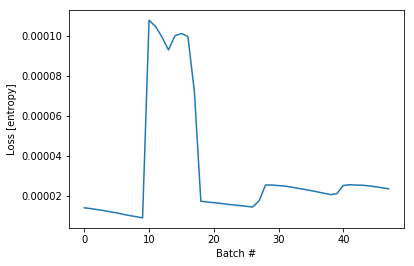

In [42]:
# ... 
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [43]:
test_subset = np.random.choice(np.arange(0, outdata['x_test'].shape[0], 1),
                               10000, replace=False)
expected_onehot = tf.convert_to_tensor(outdata['y_test'][test_subset])
print(np.count_nonzero (expected_onehot, axis=0))

%time y_pred = model(tf.convert_to_tensor(outdata['x_test'][test_subset], dtype=tf.float32))

[5829  255 3411  505]
CPU times: user 2min 30s, sys: 46.8 s, total: 3min 17s
Wall time: 2min 5s


In [44]:
print(Counter(np.argmax(y_pred, axis=1)))

Counter({1: 9991, 3: 9})


In [56]:
# np.argmax( outdata['y_test'][test_subset, :], axis=1) .shape
y_pred.shape

TensorShape([Dimension(10000), Dimension(4)])

In [57]:
# confusion... 
confus = tf.confusion_matrix(
    np.argmax( outdata['y_test'][test_subset, :], axis=1),  # labels

    np.argmax(y_pred, axis=1), # predictions
    num_classes=4)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [58]:
confus

<tf.Tensor: id=4963846, shape=(4, 4), dtype=int32, numpy=
array([[   0, 5820,    0,    9],
       [   0,  255,    0,    0],
       [   0, 3411,    0,    0],
       [   0,  505,    0,    0]], dtype=int32)>

In [59]:
Counter(np.argmax( outdata['y_test'][test_subset, :], axis=1))

Counter({2: 3411, 0: 5829, 3: 505, 1: 255})

In [ ]:
# So one change I made above ^^  was changing the LSTM layer size from 64 to 256, 
#   since that's actually the size of the input.

In [60]:
# Oh but how do predictions look like on the training set?
# choose some 10,000 randoms...
print(outdata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, outdata['x_train'].shape[0], 1),
                               10000, replace=False)

(446110, 256, 1)


In [62]:
Counter(np.argmax(outdata['y_train'][train_subset, :], axis=1))

Counter({2: 3992, 0: 5303, 3: 531, 1: 174})

In [64]:
# ok.. pred for the train set...
%time y_pred_train = model(tf.convert_to_tensor(outdata['x_train'][train_subset], dtype=tf.float32))

CPU times: user 2min 37s, sys: 56.4 s, total: 3min 34s
Wall time: 4min 4s


In [65]:
# confusion... 
tf.confusion_matrix(
    np.argmax( outdata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)

<tf.Tensor: id=4996054, shape=(4, 4), dtype=int32, numpy=
array([[   0, 2651,    0, 2652],
       [   0,   91,    0,   83],
       [   0, 1917,    0, 2075],
       [   0,  262,    0,  269]], dtype=int32)>

In [ ]:
# Well train error is also terrible, but it's actually looking like it's randomly,
# splitting between class=1 and class=3,
#.
# whereas in the test confusion matrix, it is basically all class=1 
#
#
# Hmm so since the minority classes are being ignored even in the train data
# that was used, then this is some kind of underfitting. 

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 265,220
Trainable params: 265,220
Non-trainable params: 0
_________________________________________________________________


In [73]:
[[x, outdata[x].shape]
 for x in ['x_train', 'y_train', 'x_test', 'y_test', 'y_train_original', 'y_test_original',]]
# outdata.keys()


[['x_train', (446110, 256, 1)],
 ['y_train', (446110, 4)],
 ['x_test', (551326, 256, 1)],
 ['y_test', (551326, 4)],
 ['y_train_original', (446110,)],
 ['y_test_original', (551326,)]]

In [74]:
reload(mu)

<module 'mytf.utils' from '/Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py'>

In [75]:
shrunkoutdata = mu.shrink_dataset_subset(
                outdata,
                training_indices,
                test_subset
                )

In [77]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'wb') as fd:
    pickle.dump(shrunkoutdata, fd)
    
    

In [80]:
train_subset.shape, np.array(training_indices).shape

((10000,), (47689,))

In [83]:

Counter(np.argmax(outdata['y_train'][training_indices, :], axis=1))

Counter({0: 10000, 1: 7689, 2: 10000, 3: 20000})

In [84]:
# oh wait crap so i was using the wrong indices for the training test... 
# ok.. pred for the train set...
%time y_pred_train = model(tf.convert_to_tensor(outdata['x_train'][training_indices], dtype=tf.float32))

CPU times: user 14min 39s, sys: 7min 23s, total: 22min 3s
Wall time: 33min 25s


In [85]:
tf.confusion_matrix(
    np.argmax( outdata['y_train'][training_indices, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)

<tf.Tensor: id=5028262, shape=(4, 4), dtype=int32, numpy=
array([[    0,     0,     0, 10000],
       [    0,  3852,     0,  3837],
       [    0,     0,     0, 10000],
       [    0,  7927,     0, 12073]], dtype=int32)>

In [ ]:
# ok darn, so it is settled. this model still underfitting. not even random even split between
# class 1 and 3 anymore. just mainly in for class=3.